In [1]:
import sys
import os

import joblib

In [2]:
import torch
import torch.nn as nn

In [3]:
sys.path.append(os.path.abspath("../.."))
from utils import read_features, read_targets, print_info_features, print_info_targets, train_val_split, get_dimensions, \
    scale, \
    metrics_r, get_device, plot_history, read_target_tensors

In [4]:
sys.path.append(os.path.abspath(".."))
from PotteryDataset import create_pottery_dataloaders, create_pottery_datasets, feature_types, feature_type_combos
from PotteryChronologyPredictor import PotteryChronologyPredictor, train

## Settings

In [5]:
# Set Working Device
device = get_device()

PyTorch Version: 2.5.1
CUDA is available
GPU: NVIDIA GeForce RTX 4080
Using Device: cuda


In [6]:
path_features = os.path.abspath(os.path.join(os.getcwd(), "../../../data/features2"))
path_targets = os.path.abspath(os.path.join(os.getcwd(), "../../../data/targets/regression"))

In [7]:
targets = ["StartYear", "YearRange"]

## Data

### Read Features and Targets

In [8]:
X = read_features(path_features, f_type="tensors")
print_info_features(X)

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_val_tfidf
Loaded X_val_bert
Loaded X_val_cannyhog
Loaded X_val_resnet
Loaded X_val_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
{
	train: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 2048]), 
		vit: 
			<class 'torch.Tensor'>
			shape = torch.Size([1528, 768]), 
	},
	val: {
		tfidf: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 300]), 
		bert: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 768]), 
		cannyhog: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2917]), 
		resnet: 
			<class 'torch.Tensor'>
			shape = torch.Size([191, 2048]), 
		vit: 
			<

In [9]:
y = read_target_tensors(path_targets)
print_info_targets(y)

Loaded y_train
Loaded y_val
Loaded y_test
{
	train: 
		<class 'torch.Tensor'>
		shape   = torch.Size([1528, 2])
	val: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191, 2])
	test: 
		<class 'torch.Tensor'>
		shape   = torch.Size([191, 2])
}


### Load Target Scaler

In [10]:
path_scaler = os.path.join(path_targets, "y_scaler.pkl")
y_scaler = joblib.load(path_scaler)

### Dimensions

In [11]:
X_dim, y_dim = get_dimensions(X, y)

X Dimensions: {'tfidf': 300, 'bert': 768, 'cannyhog': 2917, 'resnet': 2048, 'vit': 768}
y Dimensions: 2


### Torch Datasets and Dataloaders

In [12]:
datasets = create_pottery_datasets(X, y)
loaders = create_pottery_dataloaders(datasets, batch_size=64)

## MLP: Pottery Chronology Predictor - Year Regressor



### Initialize Models

In [13]:
hidden_size = 256

models = {
             ft: PotteryChronologyPredictor([X_dim[ft]], y_dim, hidden_size, device, chronology_target="years")
             for ft in feature_types
         } | {
             ft_txt + " + " + ft_img: PotteryChronologyPredictor([X_dim[ft_txt], X_dim[ft_img]], y_dim, hidden_size, device, chronology_target="years")
             for ft_txt, ft_img in feature_type_combos
         }

In [14]:
for ft, model in models.items():
    print(f"\n\nMODEL SUMMARY - FEATURE TYPE: {ft.upper()}")
    model.summary()



MODEL SUMMARY - FEATURE TYPE: TFIDF
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
PotteryChronologyPredictor               [1, 300]                  [1, 2]                    --                        --
├─ModuleList: 1-1                        --                        --                        --                        --
│    └─Sequential: 2-1                   [1, 300]                  [1, 256]                  --                        --
│    │    └─Linear: 3-1                  [1, 300]                  [1, 256]                  77,056                    77,056
│    │    └─ReLU: 3-2                    [1, 256]                  [1, 256]                  --                        --
│    │    └─Dropout: 3-3                 [1, 256]                  [1, 256]                  --                        --
├─Sequential: 1-2                        [1, 256]                  [1, 2]                    --  

### Train Models



** FEATURE SET: TFIDF **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 934.70it/s, loss=0.7487]


** Early stop | ran: 31/50 epochs | final: epoch 21 | train_loss: 0.2289, val_loss: 0.7071, mae: [33.01, 10.73], rmse: [44.86, 13.53], r2: [0.54, 0.19], medae: [25.45, 9.09], 


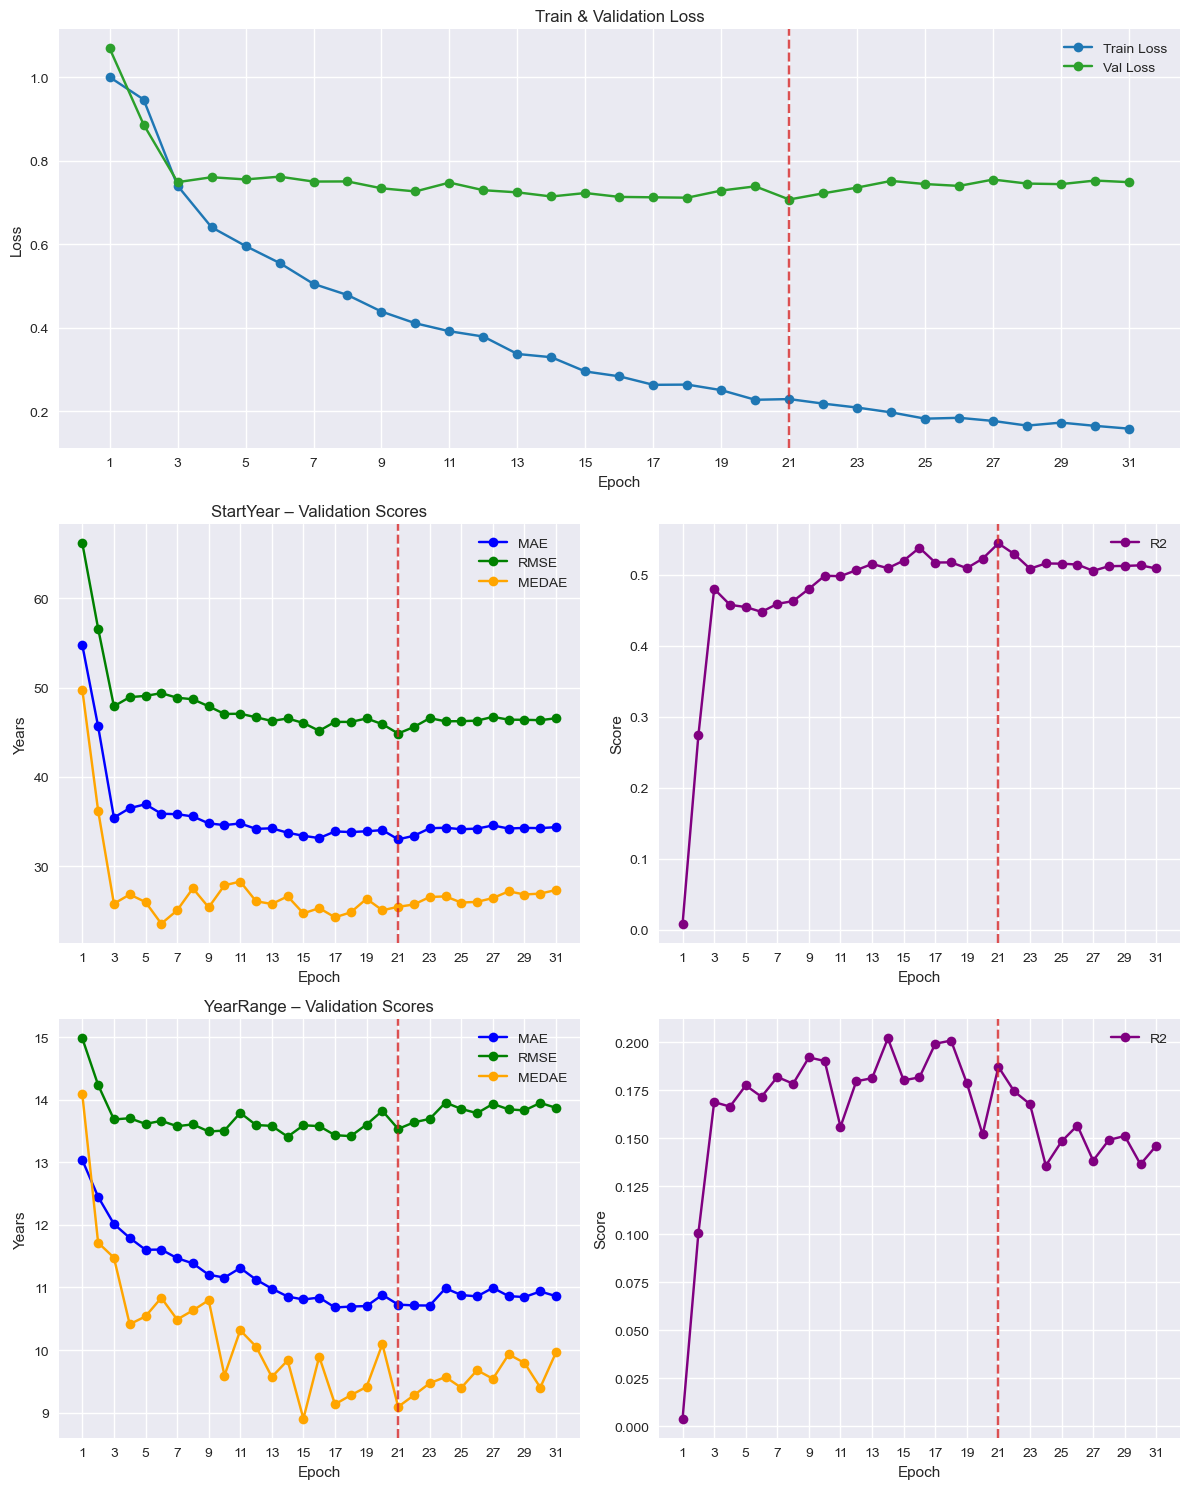



** FEATURE SET: BERT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1817.03it/s, loss=0.8686]


** Early stop | ran: 35/50 epochs | final: epoch 25 | train_loss: 0.6083, val_loss: 0.8609, mae: [40.38, 12.47], rmse: [53.34, 14.40], r2: [0.36, 0.08], medae: [29.34, 12.06], 


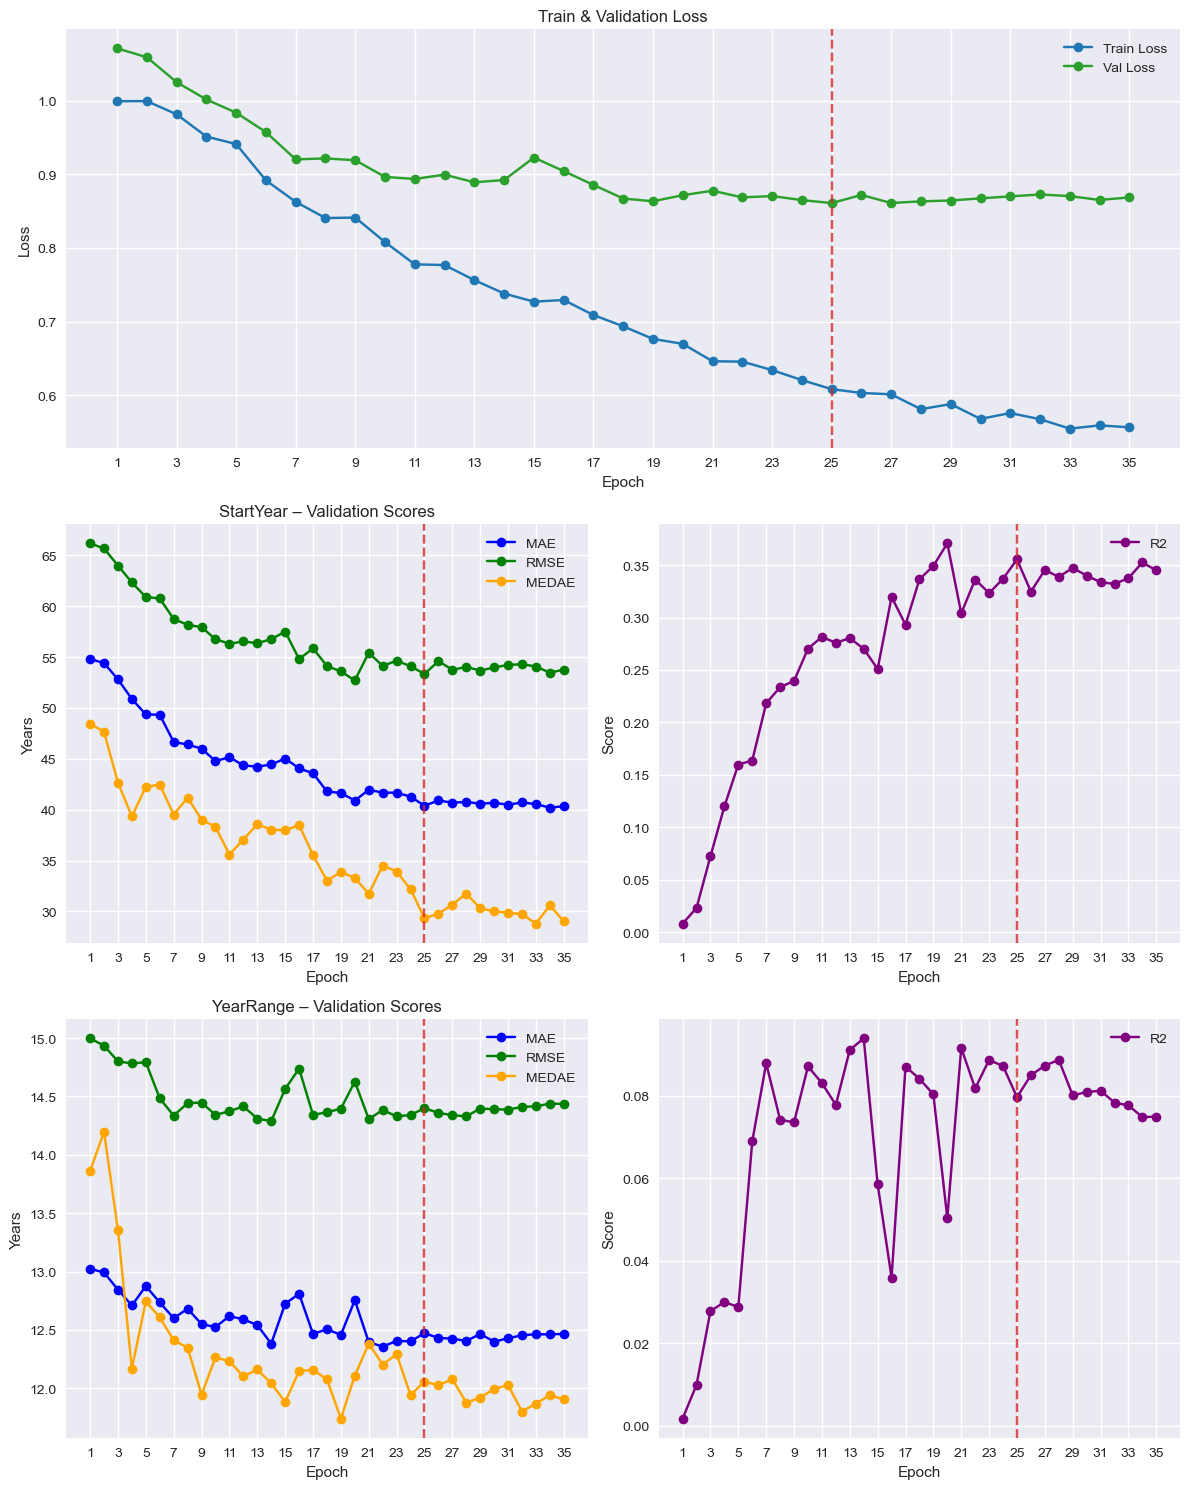



** FEATURE SET: CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 970.60it/s, loss=1.0781]


** Early stop | ran: 17/50 epochs | final: epoch 07 | train_loss: 0.9983, val_loss: 1.0764, mae: [55.09, 13.02], rmse: [66.59, 14.99], r2: [-0.00, 0.00], medae: [49.31, 13.89], 


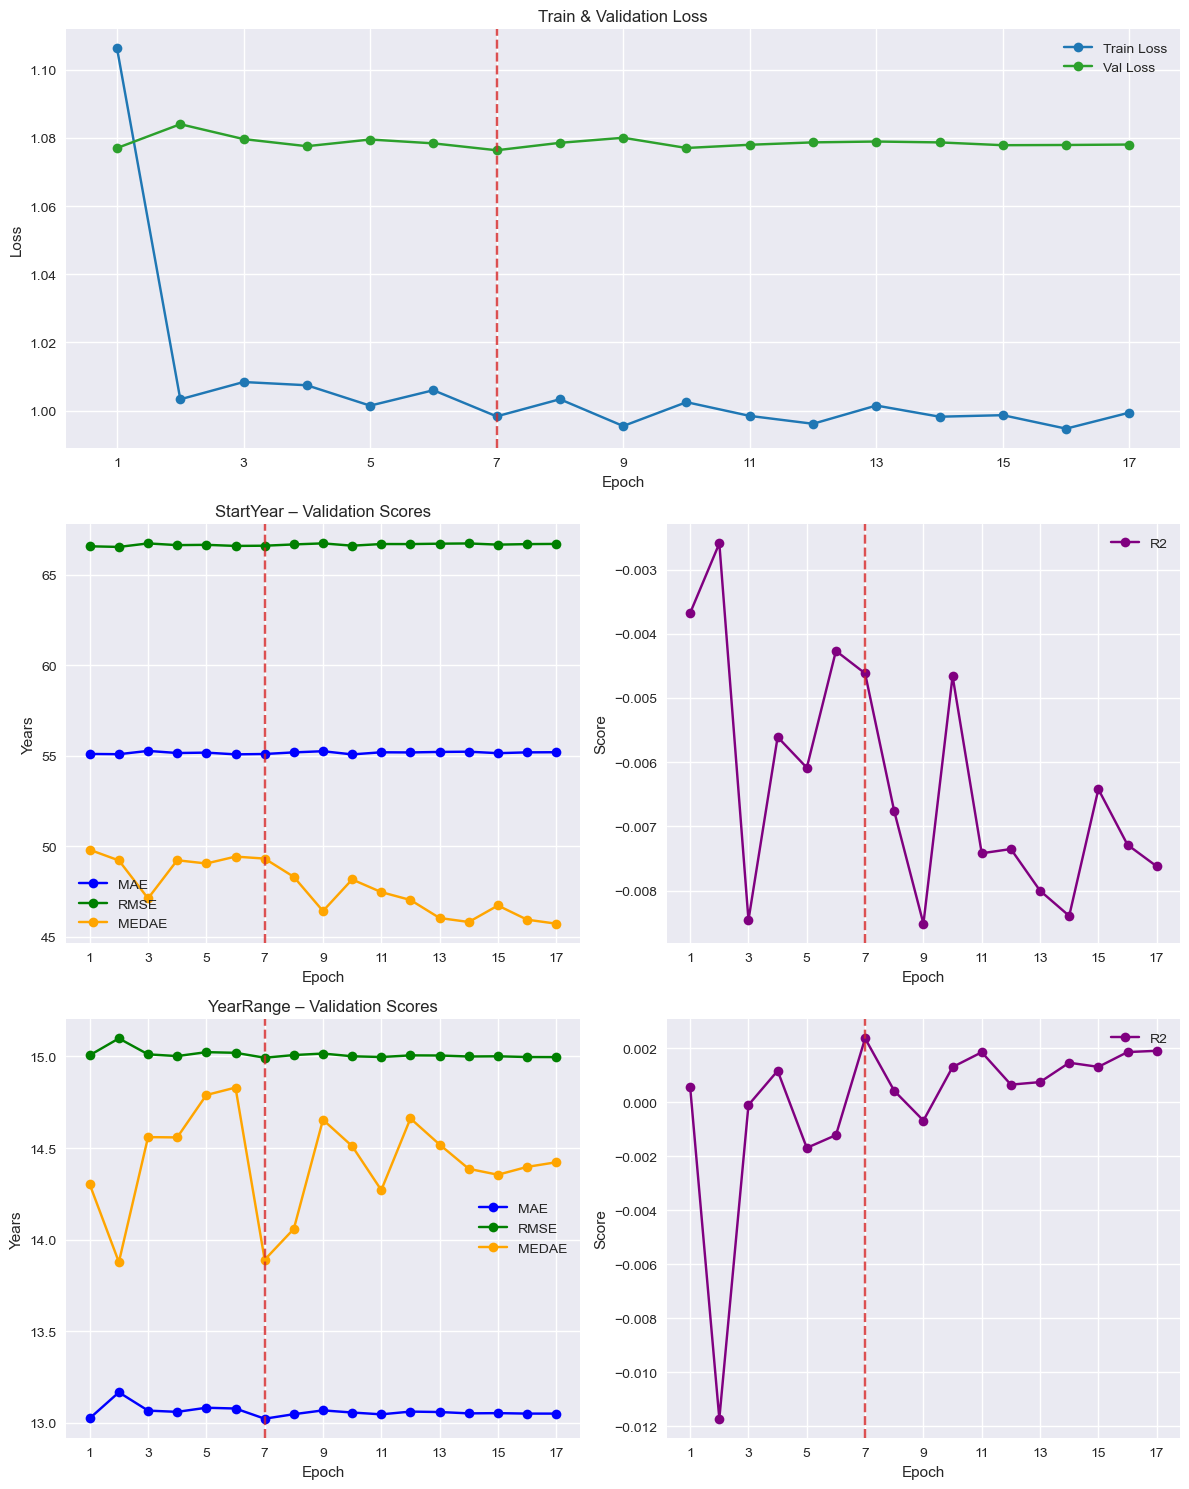



** FEATURE SET: RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 636.11it/s, loss=1.0114]


** Early stop | ran: 23/50 epochs | final: epoch 13 | train_loss: 0.7573, val_loss: 0.9828, mae: [48.79, 12.59], rmse: [60.78, 14.80], r2: [0.16, 0.03], medae: [43.91, 10.61], 


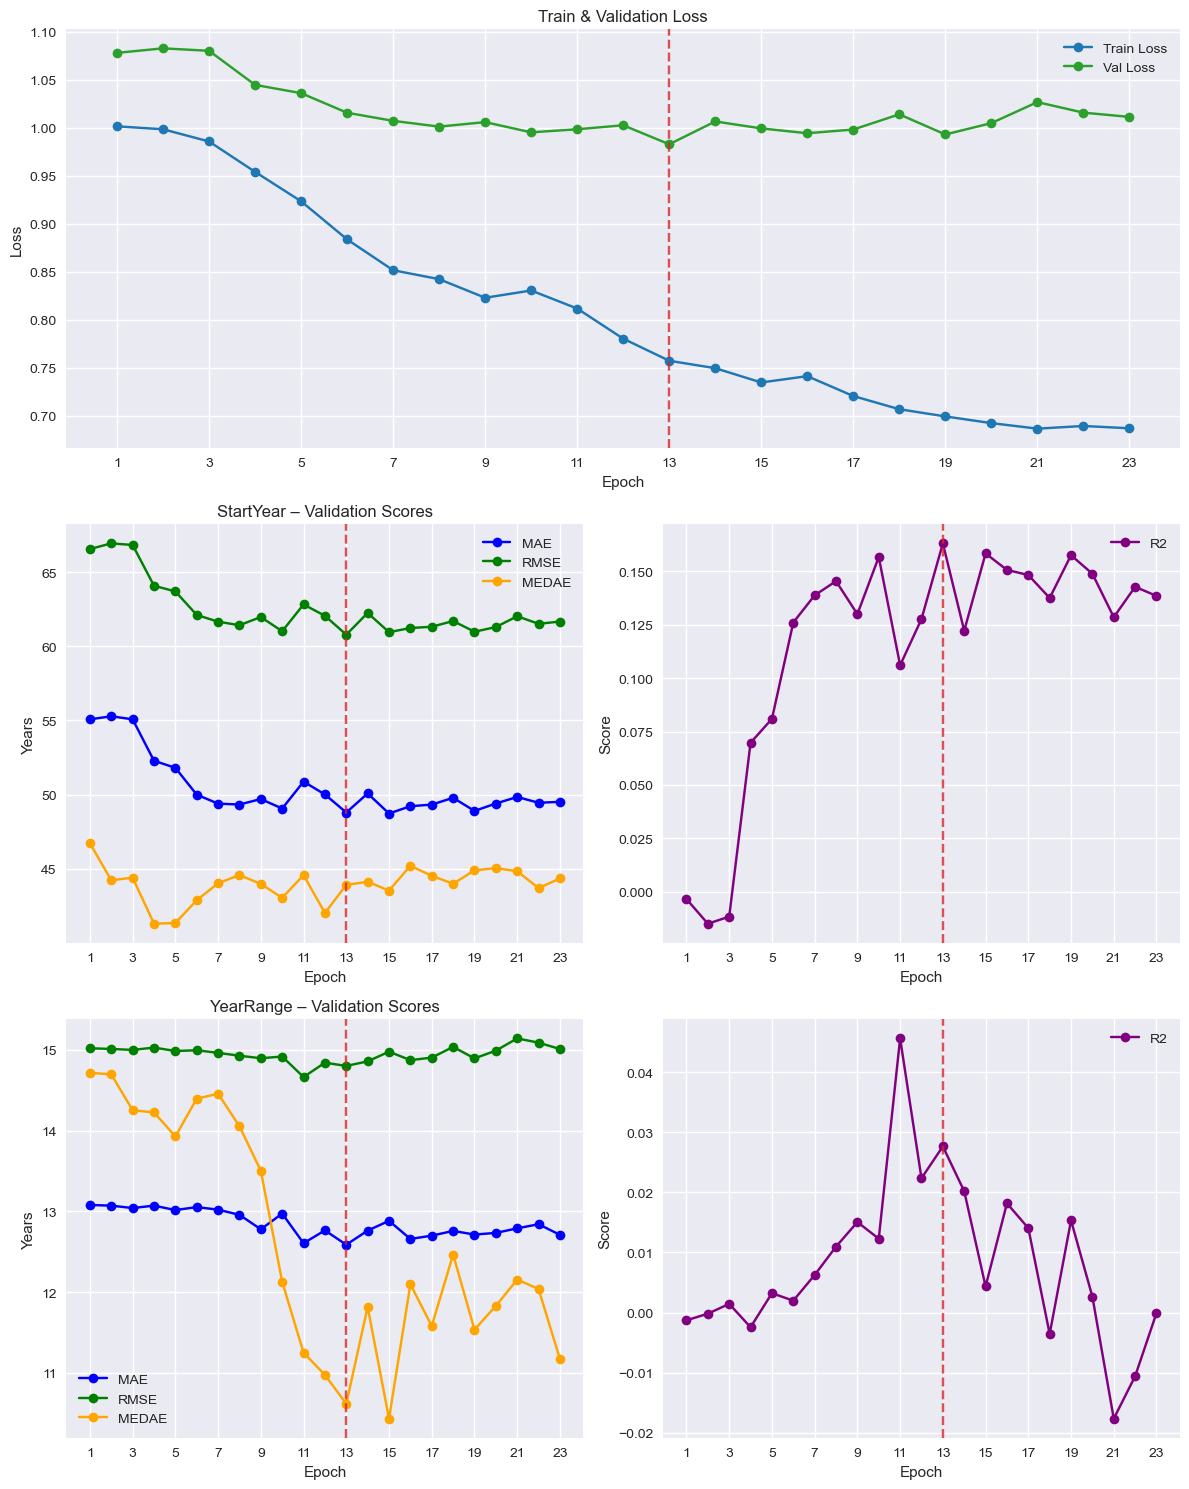



** FEATURE SET: VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 938.95it/s, loss=0.9882]


** Early stop | ran: 20/50 epochs | final: epoch 10 | train_loss: 0.7600, val_loss: 0.9834, mae: [48.39, 12.82], rmse: [60.30, 14.88], r2: [0.18, 0.02], medae: [44.50, 11.89], 


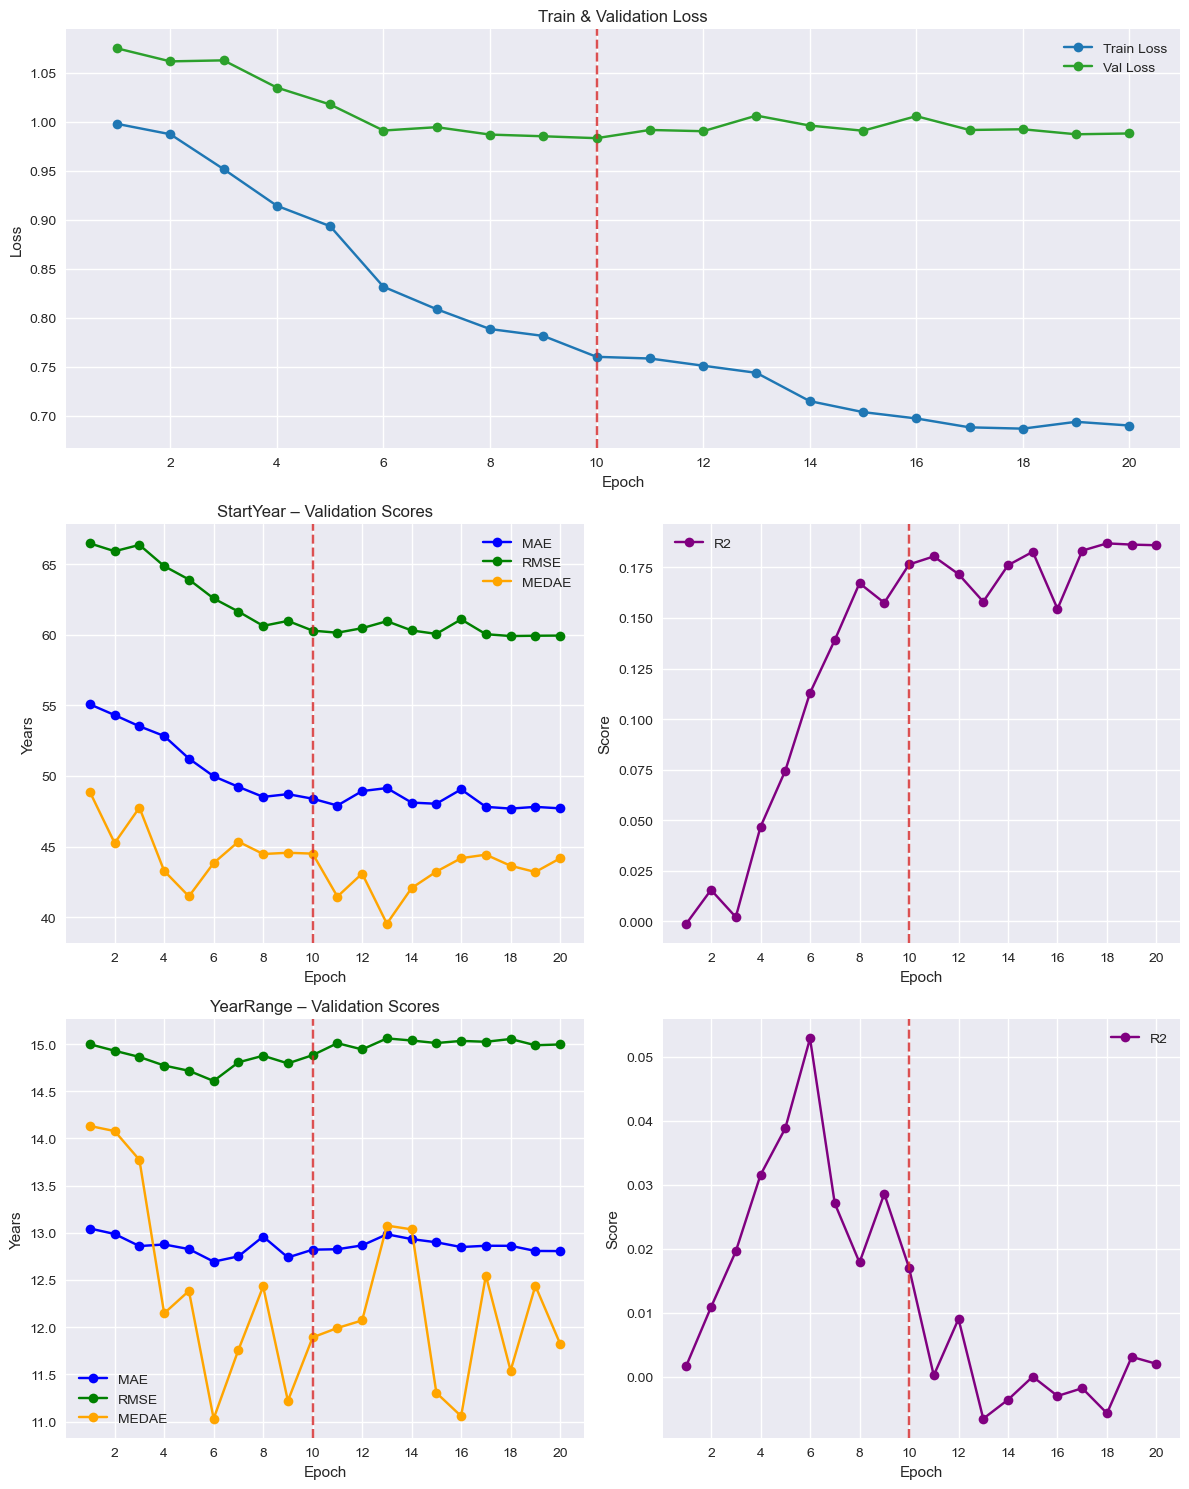



** FEATURE SET: TFIDF + CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 713.72it/s, loss=0.7324]


** Early stop | ran: 28/50 epochs | final: epoch 18 | train_loss: 0.3245, val_loss: 0.7252, mae: [33.66, 10.86], rmse: [46.10, 13.62], r2: [0.52, 0.18], medae: [24.19, 9.32], 


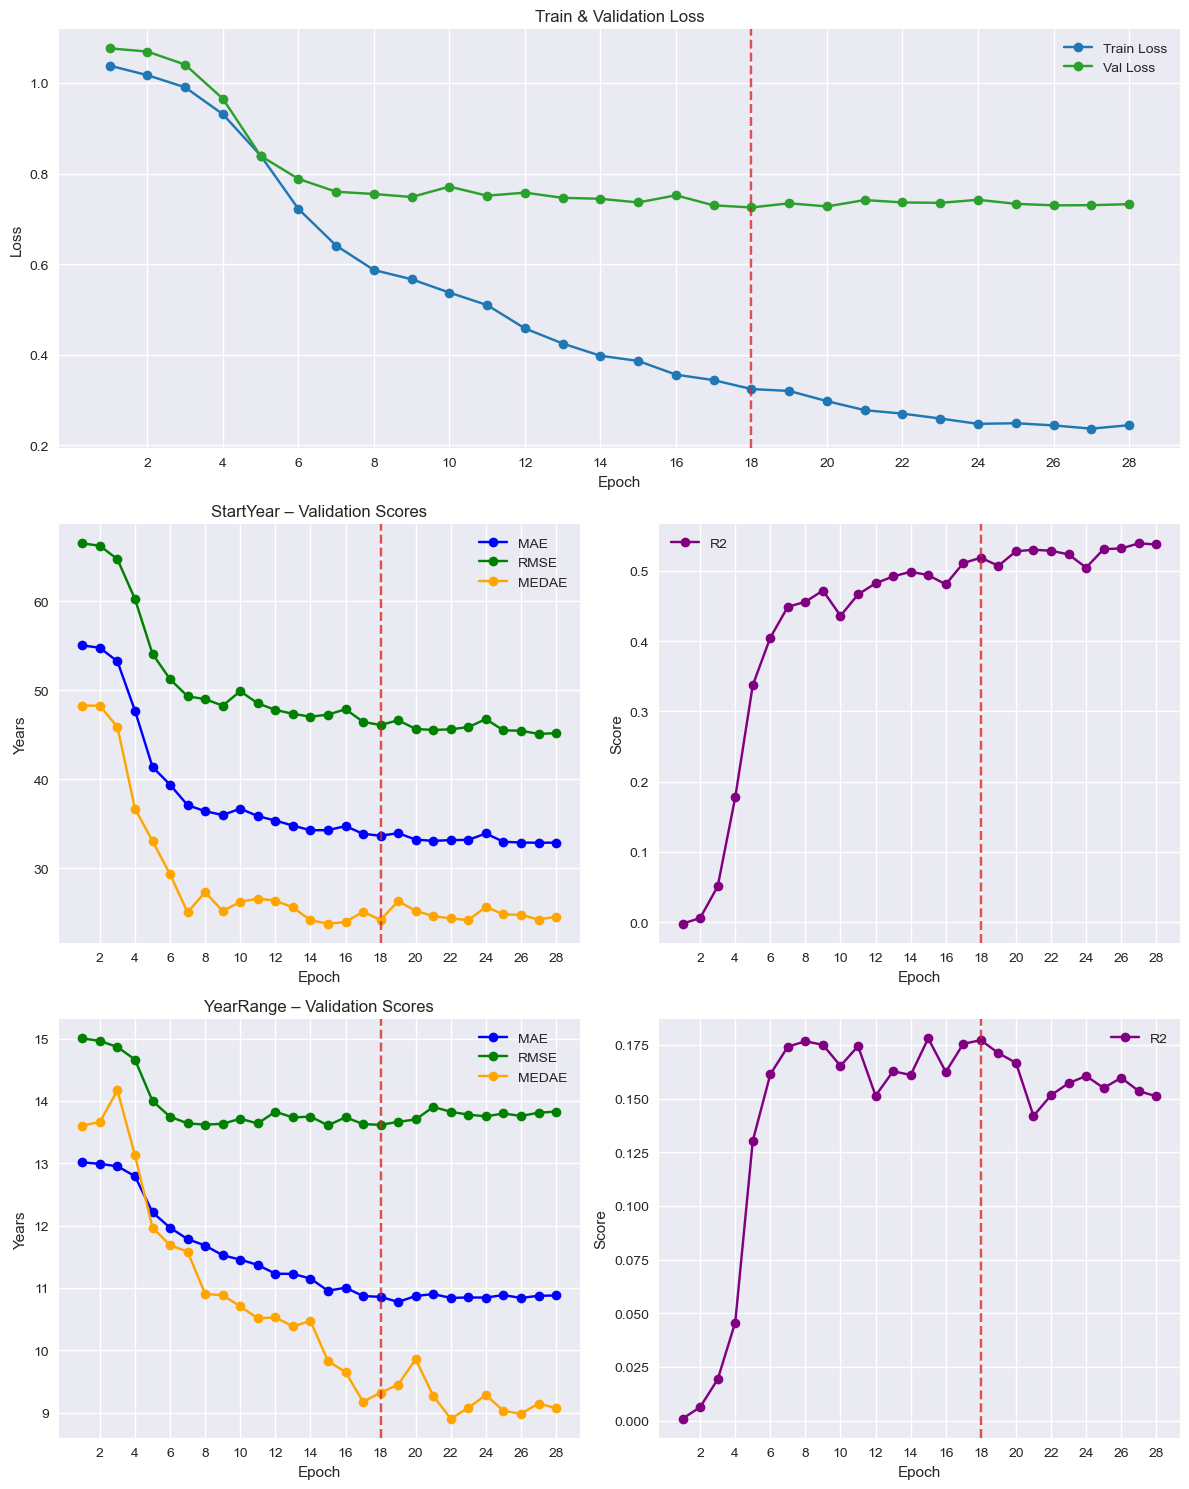



** FEATURE SET: TFIDF + RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 990.39it/s, loss=0.7496]


** Early stop | ran: 23/50 epochs | final: epoch 13 | train_loss: 0.3029, val_loss: 0.7096, mae: [35.00, 10.59], rmse: [47.12, 13.26], r2: [0.50, 0.22], medae: [27.41, 9.32], 


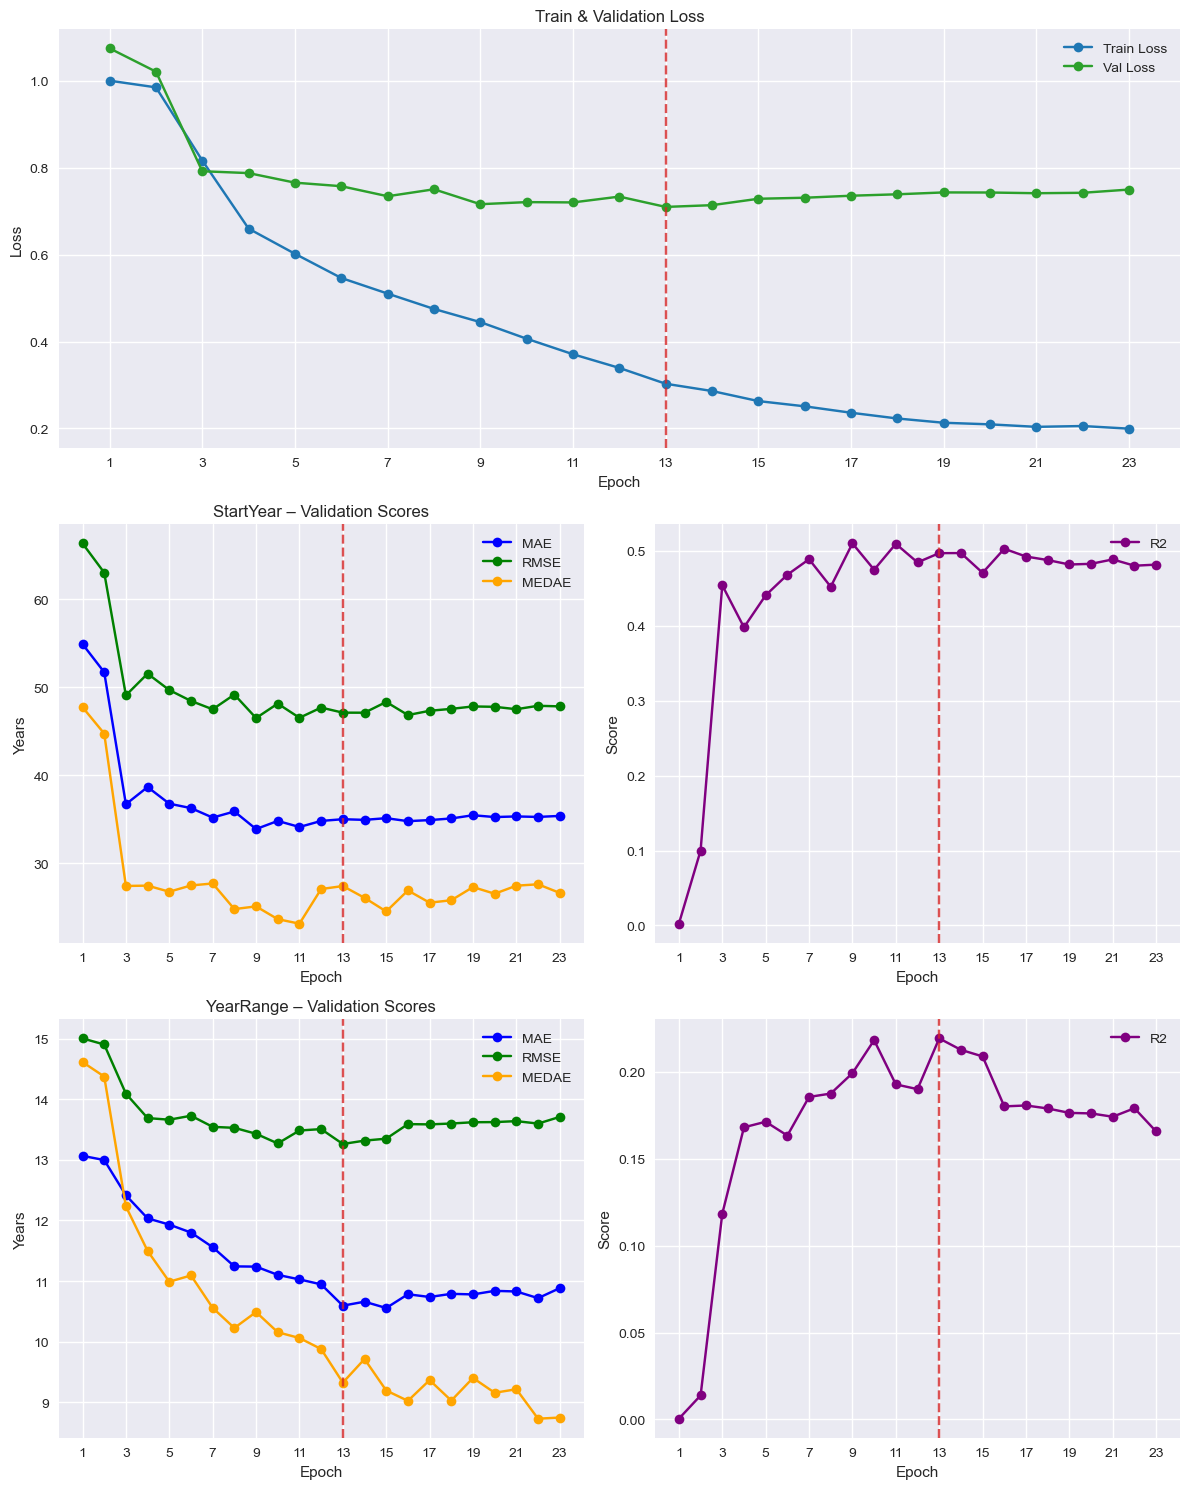



** FEATURE SET: TFIDF + VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1006.79it/s, loss=0.7516]


** Early stop | ran: 21/50 epochs | final: epoch 11 | train_loss: 0.3461, val_loss: 0.7147, mae: [33.77, 10.85], rmse: [45.49, 13.55], r2: [0.53, 0.19], medae: [24.84, 8.76], 


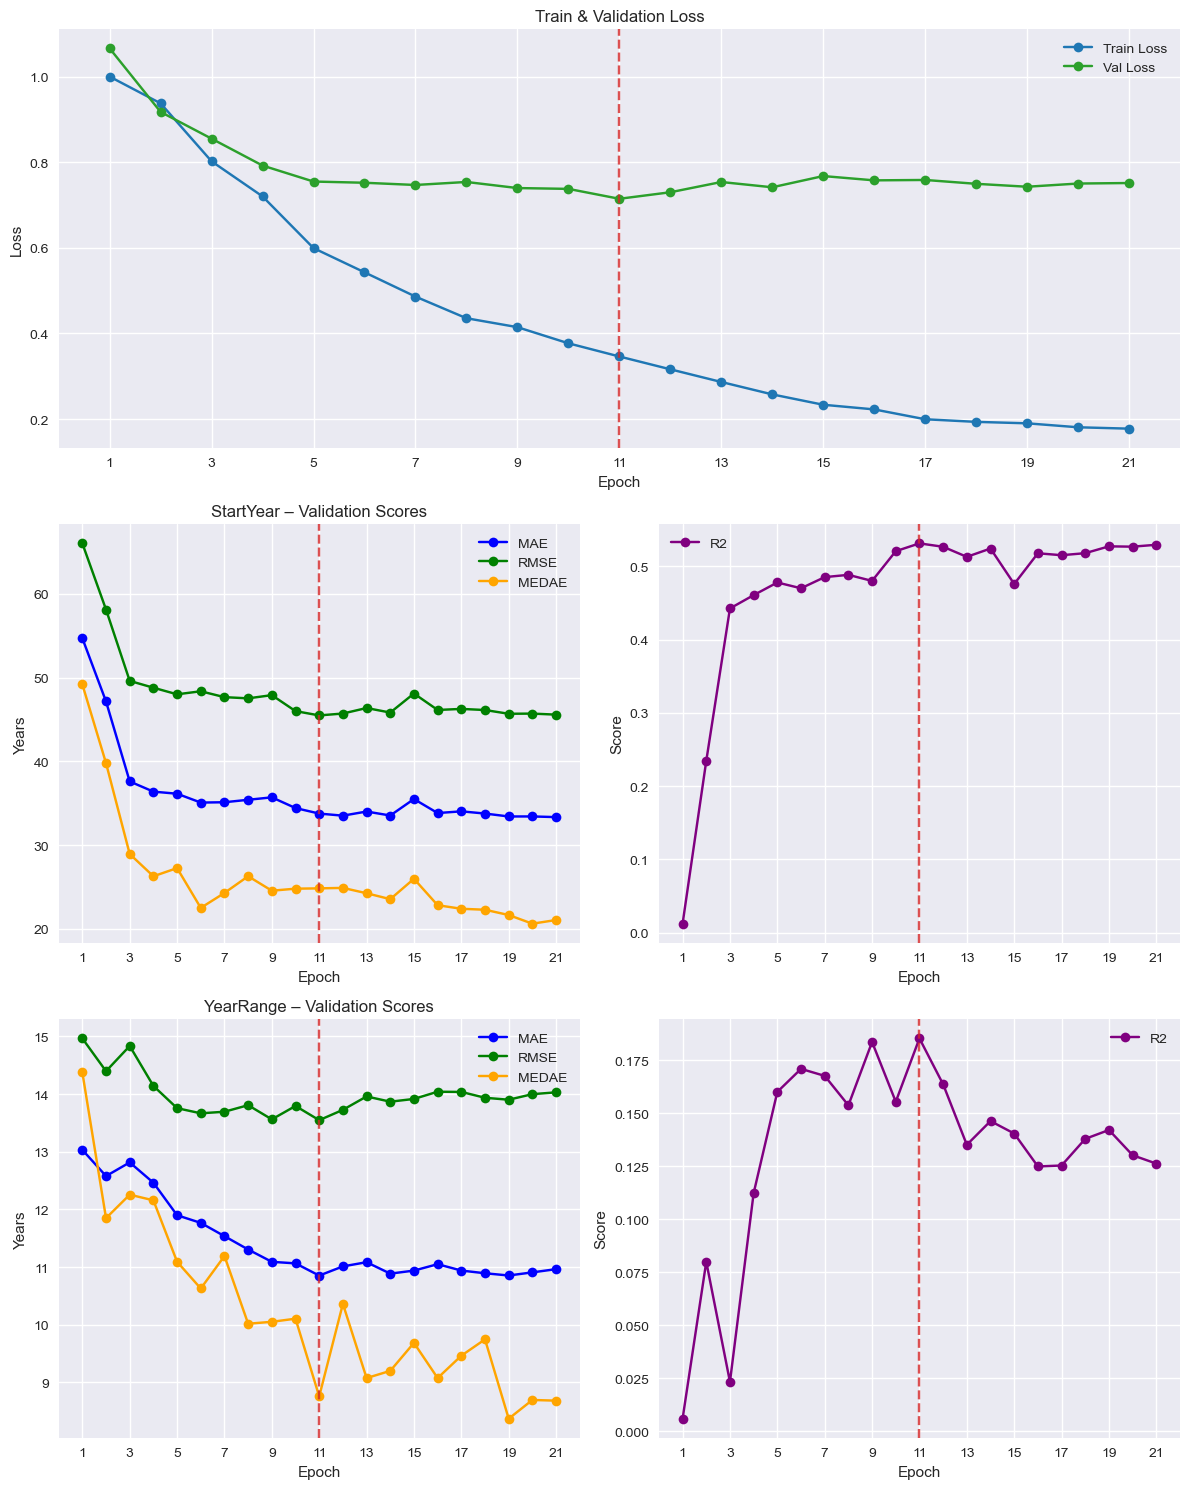



** FEATURE SET: BERT + CANNYHOG **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 997.22it/s, loss=0.8591]


** Early stop | ran: 44/50 epochs | final: epoch 34 | train_loss: 0.5960, val_loss: 0.8423, mae: [40.98, 12.14], rmse: [53.41, 14.15], r2: [0.35, 0.11], medae: [34.09, 11.85], 


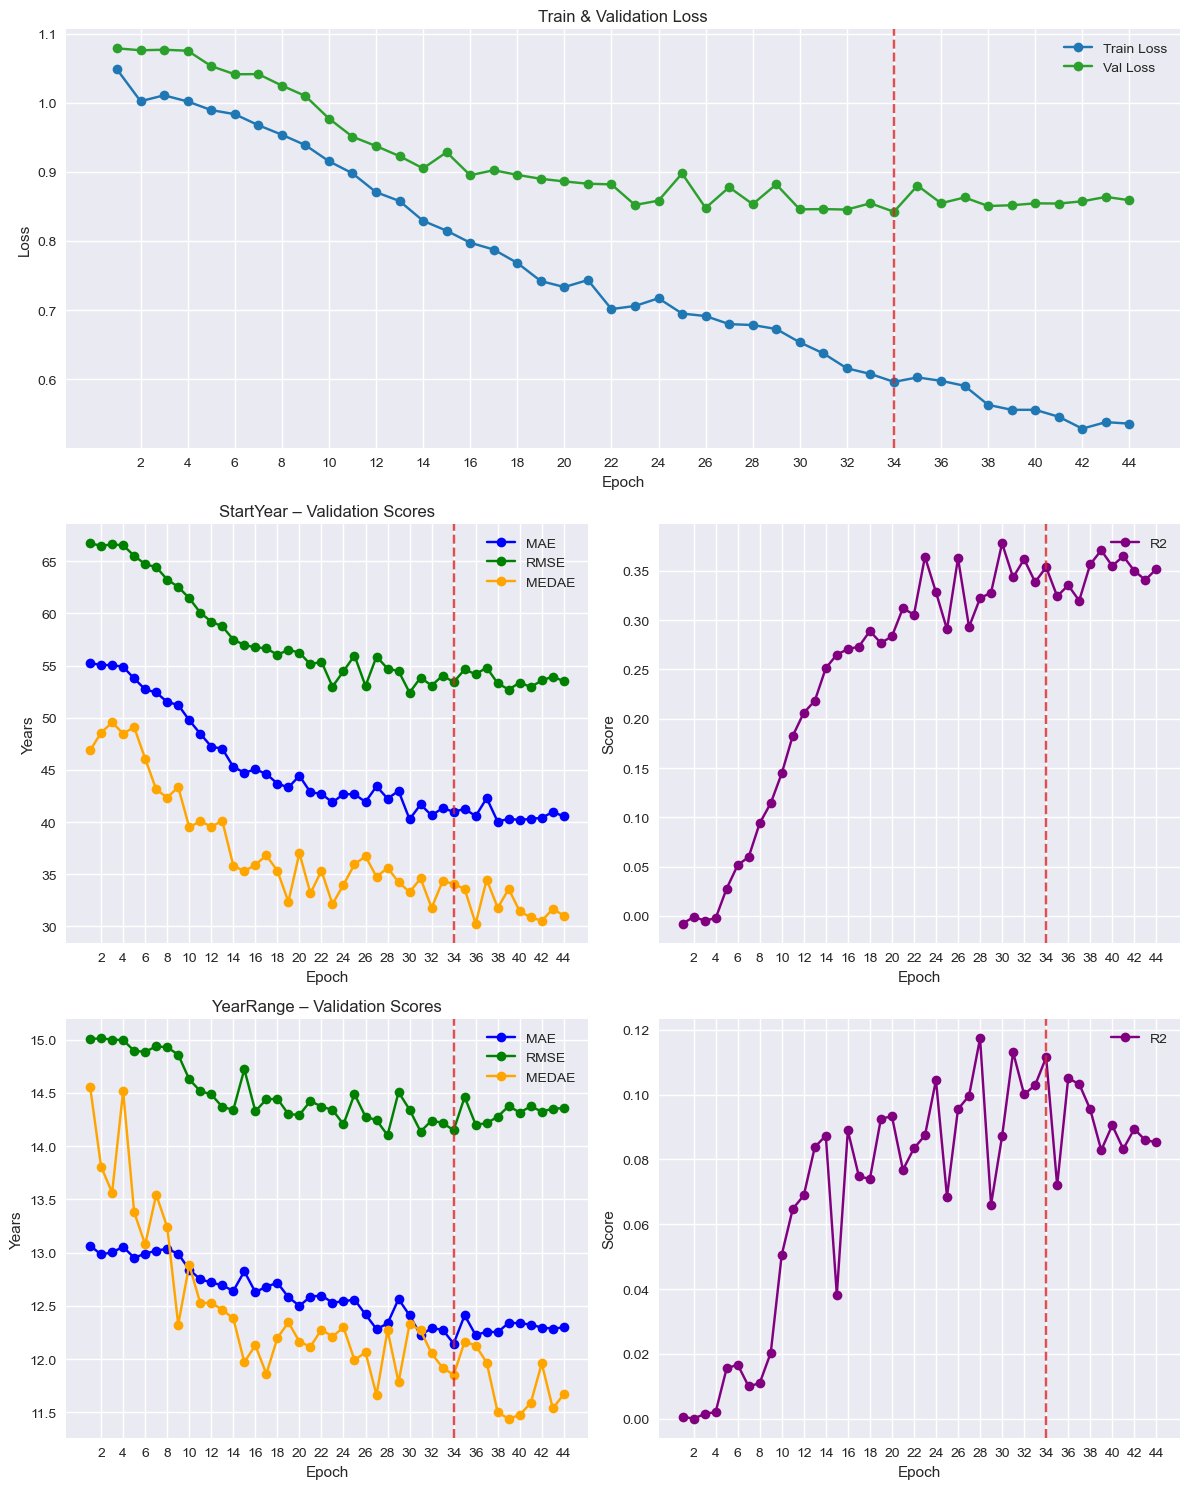



** FEATURE SET: BERT + RESNET **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 949.73it/s, loss=0.8767]


** Early stop | ran: 19/50 epochs | final: epoch 09 | train_loss: 0.6744, val_loss: 0.8656, mae: [43.62, 12.31], rmse: [55.03, 14.20], r2: [0.31, 0.10], medae: [38.37, 11.65], 


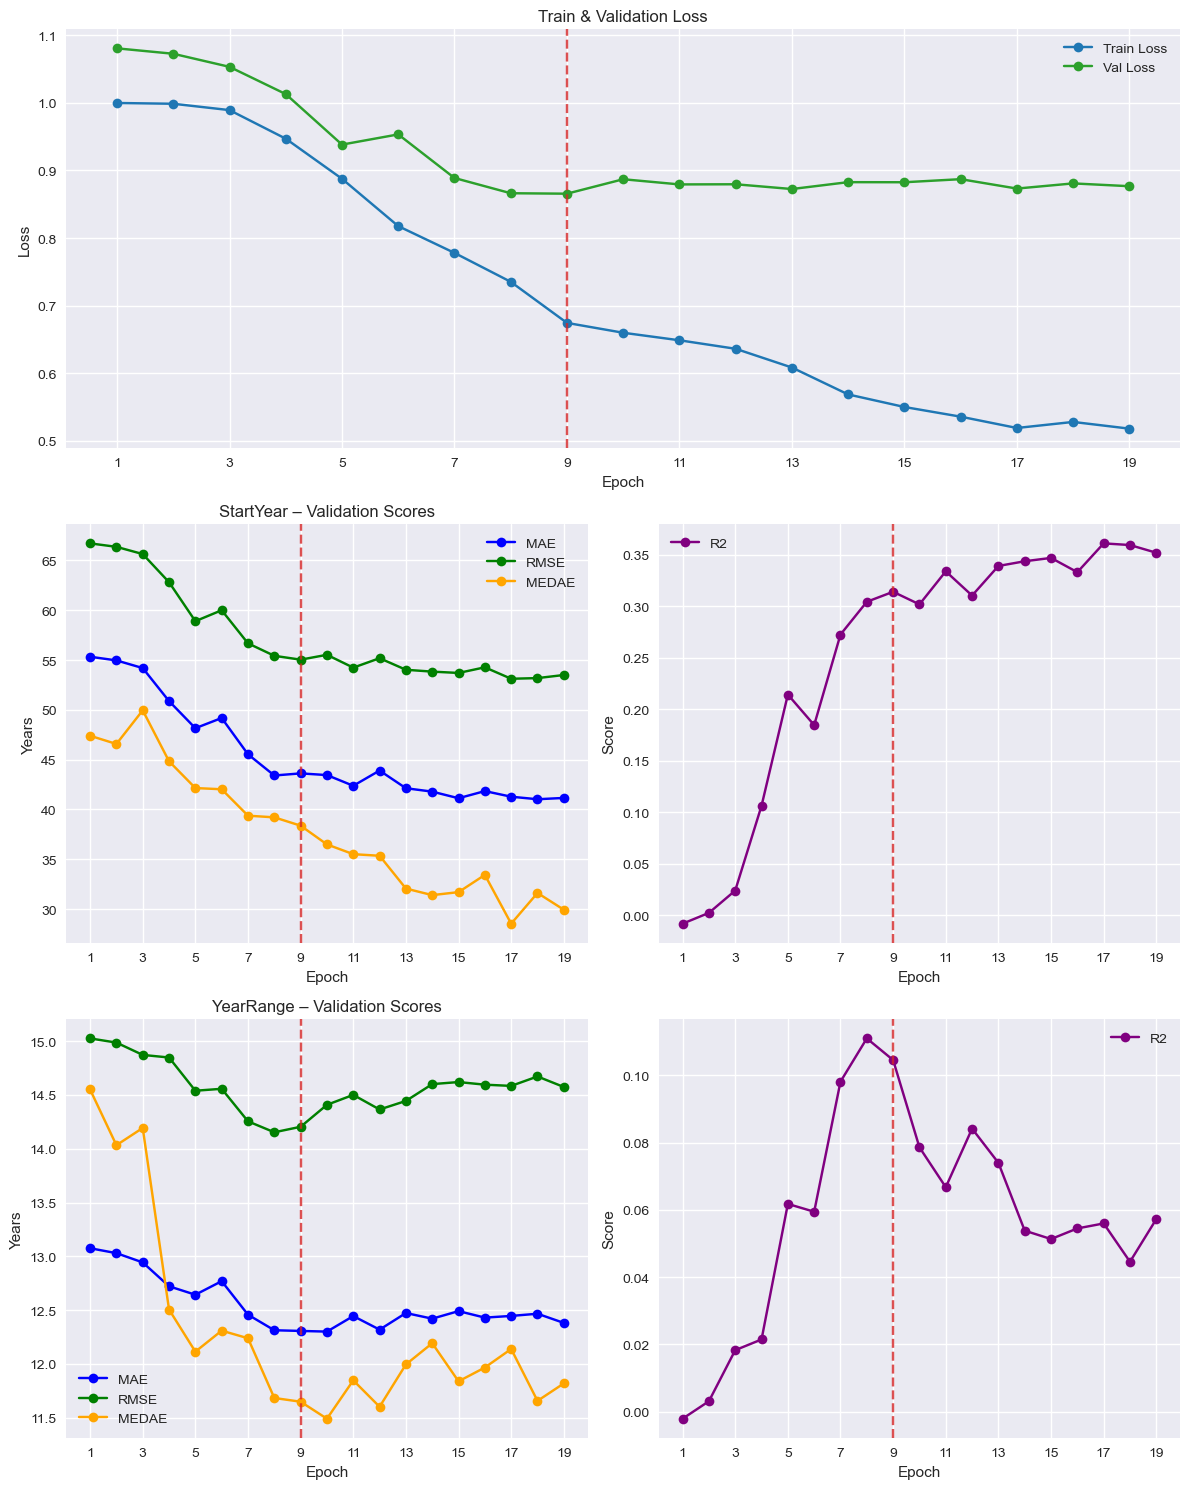



** FEATURE SET: BERT + VIT **
** Training Running...


            [ Val ]: 100%|██████████| 3/3 [00:00<00:00, 1194.73it/s, loss=0.8676]


** Early stop | ran: 20/50 epochs | final: epoch 10 | train_loss: 0.6577, val_loss: 0.8512, mae: [40.82, 12.49], rmse: [52.84, 14.34], r2: [0.37, 0.09], medae: [35.51, 11.88], 


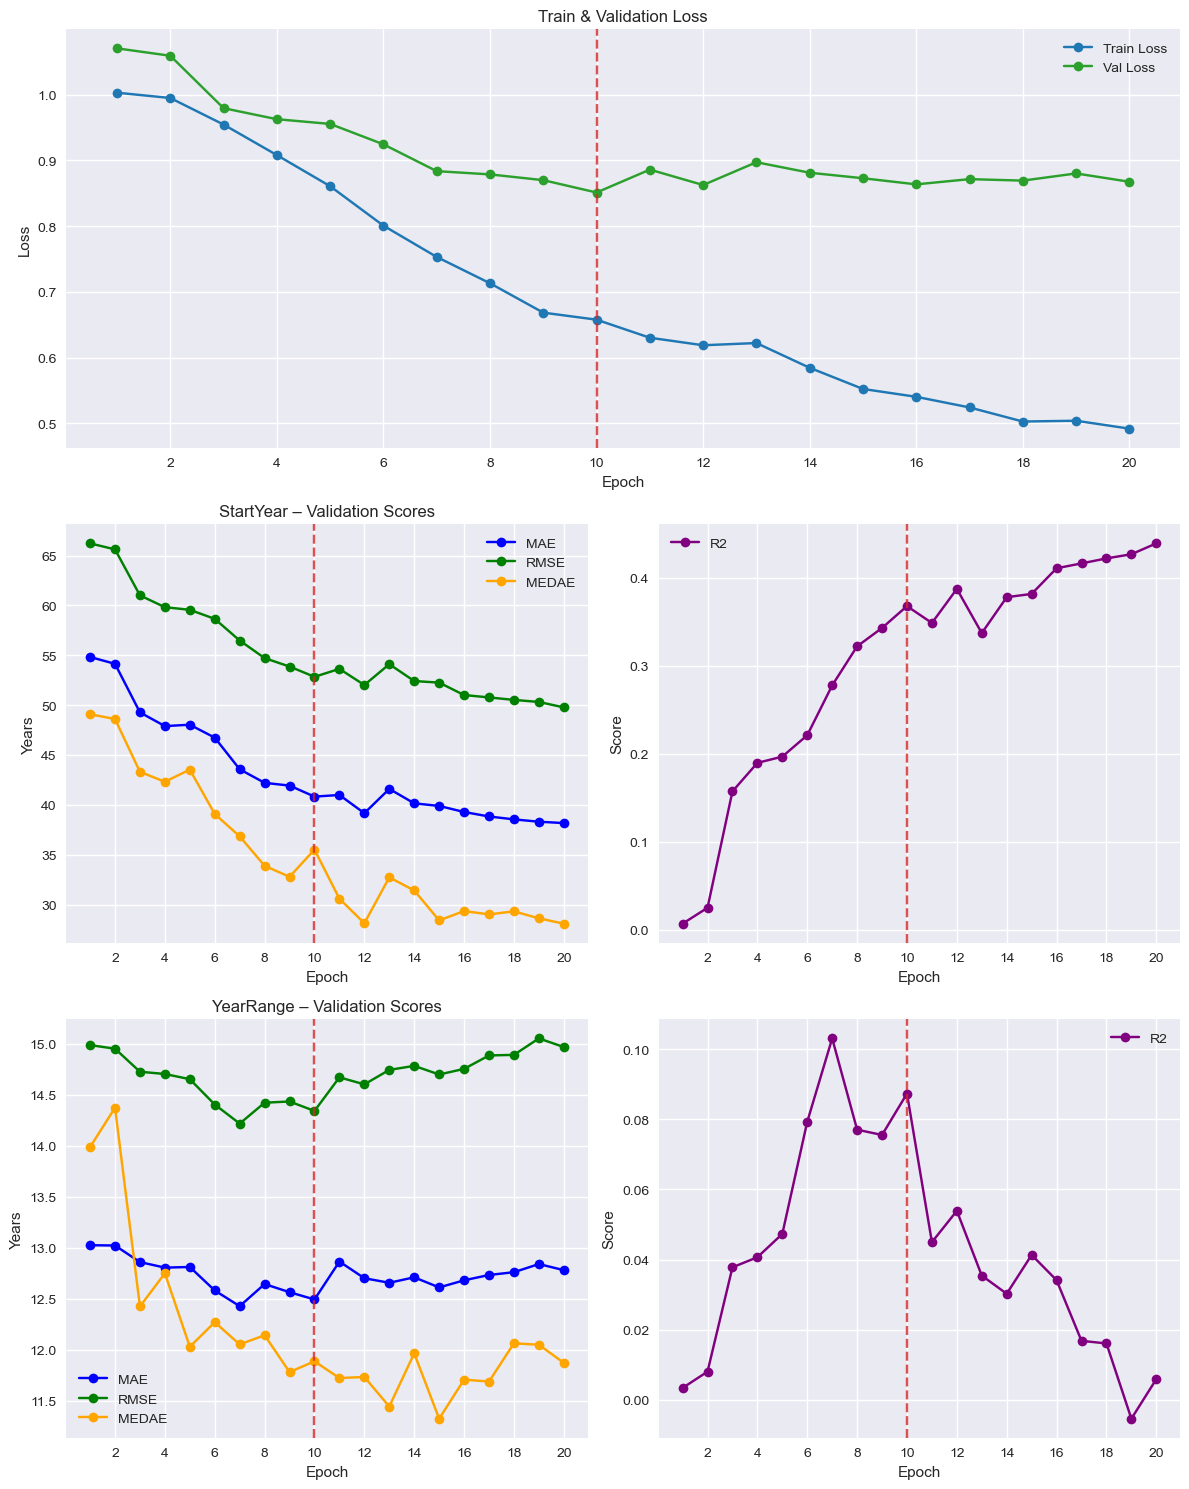

In [15]:
criterion = nn.MSELoss()
metrics = metrics_r

for ft, model in models.items():
    print(f"\n\n** FEATURE SET: {ft.upper()} **")
    models[ft], history = train(model, loaders["train"][ft], loaders["val"][ft], criterion, metrics, y_scaler)
    plot_history(history, targets)